# Quantum Chemistry with VQE

This notebook demonstrates the basic workflow for molecular ground state calculations using PennyLane. 

\* *Demonstrated on $H_{2}$ and $H_{3}^+$ molecules.*

## First Example

In the first example, we will see how a molecule is defined in qubits and how the HF method is applied to calculate the slater determinant.

In [59]:
# Import statements

import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem # qchem module to perform quantum chemistry simulations
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### 1. Define $H_{2}$ Molecule
Define a molecule with two hydrogen atoms with bond length of 0.673 Angstroms, which is close to the average experimental bond length. Bond lengths can be looked up in a chemistry database (e.g. https://cccbdb.nist.gov/alldata1x.asp) or by using the implemented qchem database (qml.qchem.mol_data).

In [60]:
symbols = ["H", "H"]
coordinates = np.array([[-0.673, 0, 0], [0.673, 0, 0]])

### 2. Define the Hamiltonian and qubits
The Hartree-Fock approximation calculates the Hamiltonian as well as the required qubits for our molecule. The Hamiltonian is represented in Pauli decomposition.

In [61]:
Hamiltonian, qubits = qchem.molecular_hamiltonian(symbols, coordinates)

print(f"Number of required Qubits: {qubits}")
print(f"HF-approximate Hamiltonian: {Hamiltonian}")

Number of required Qubits: 4
HF-approximate Hamiltonian: -0.059722777506507174 * I([0, 1, 2, 3]) + 0.17574790106889876 * Z(0) + 0.17574790106889876 * Z(1) + 0.1700120046062239 * (Z(0) @ Z(1)) + -0.23663556589795115 * Z(2) + 0.12222295790716331 * (Z(0) @ Z(2)) + 0.16714112448986262 * (Z(1) @ Z(2)) + 0.044918166582699315 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.044918166582699315 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.044918166582699315 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.044918166582699315 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.23663556589795115 * Z(3) + 0.16714112448986262 * (Z(0) @ Z(3)) + 0.12222295790716331 * (Z(1) @ Z(3)) + 0.1756999882843957 * (Z(2) @ Z(3))


### 3. Build the Quantum Circuit
For the circuit, we build a quantum device and node. We then use the BasisState operation to initialize the qubits and return the expectation value of the states' Hamiltonian.

In [62]:
dev = qml.device("default.qubit", wires = qubits)

@qml.qnode(dev)
def exp_energy(state):
    qml.BasisState(np.array(state), range(qubits))
    return qml.expval(Hamiltonian)

After building the circuit, we run an example state and calculate its energy:

In [63]:
exp_energy([1, 0, 1, 0]) # jordan wigner representation

tensor(-0.4952711, requires_grad=True)

### 4. Hartree-Fock Method /  Slater determinant

We can see that our random state guess doesn't represent the ground state, as the energy is *not* the minimum. Therefore, we will use the Hartree-Fock method to approximate the ground state and determine it's expectation value.

\*  Slater determinant: describes the wave function of a multi-fermionic system. In general, as well as in our case, a single Slater determinant is used as an approximation to the electronic wavefunction in Hartree–Fock theory. 

In [64]:
HF = qchem.hf_state(electrons=2, orbitals=qubits) # orbitals refers to spin orbitals
print(f"Ground State calculated by HF method: {HF}")
print(f"Energy of the HF ground state: {exp_energy(HF)} Ha")

Ground State calculated by HF method: [1 1 0 0]
Energy of the HF ground state: -1.1175058833436393 Ha


In [65]:
h2_hf_energy = exp_energy(HF)
print(f"Comparison for the H₂ molecule:")
print(f"Random state [1,0,1,0]: {exp_energy([1, 0, 1, 0]):.8f} Ha")
print(f"Hartree-Fock state:     {h2_hf_energy:.8f} Ha")
print(f"HF improvement:         {(exp_energy([1, 0, 1, 0]) - h2_hf_energy)*1000:.3f} mHa")

Comparison for the H₂ molecule:
Random state [1,0,1,0]: -0.49527110 Ha
Hartree-Fock state:     -1.11750588 Ha
HF improvement:         622.235 mHa


We have a much better starting point at -1.117 Ha. This assumes electrons move independently, but it's still not returning the absolute minimum. 

This is why it needs a post-HF workflow, like the variational quantum eigensolver (VQE), which can capture the missing electron correlations to find the true ground state.

## Second Example with Optimization
For this example, we will simulate a $H_{3}^+$ molecule with two electrons (+1 charge). In addition to our first Ansatz, we will use a VQE algorithm to optimize our workflow and find the ground state.

### 1. Define molecule and determine the HF state

In [75]:
symbols = ["H", "H", "H"]
coordinates = np.array([[0.0102, 0.0442, 0.0], [0.9867, 1.6303, 0.0], [1.8720, -0.0085, 0.0]]) # coordinates given by DB

H, qb = qchem.molecular_hamiltonian(symbols, coordinates, charge=1)

HF_state = qchem.hf_state(2, qb)
print(f"Ground State calculated by HF method: {HF_state}")

Ground State calculated by HF method: [1 1 0 0 0 0]


### 2. Determine initial HF-Energy
We are using the same circuit as before to initalize our HF state and calculate its expected energy.

In [76]:
dev = qml.device("default.qubit", qb)

@qml.qnode(dev)
def exp_energy(state):
    qml.BasisState(np.array(state), range(qb))
    return qml.expval(H)

In [77]:
h3_hf_energy = exp_energy(HF_state)
print(f"H₃⁺ Hartree-Fock energy: {h3_hf_energy:.8f} Ha")

H₃⁺ Hartree-Fock energy: -1.24655016 Ha


### 3. The VQE Ansatz

For the Ansatz, we choose the superposition:

$$\alpha \ket{110000} + \beta \ket{001100} + \gamma \ket{000011}$$

In the HF approximation some interactions between the electrons are neglected, which are strongest when they are in the same energy level. Using this Ansatz accounts for the errors occurring in the HF method.

In [78]:
def ansatz(params):
    qml.BasisState(HF_state, range(qb))
    qml.DoubleExcitation(params[0], wires=[0,1,2,3])
    qml.DoubleExcitation(params[1], wires=[0,1,4,5])

### 4. The Cost Function
With our Ansatz, we can now evaluate the minimum energy depending on the angles $\theta_1$ and $\theta_2$ in the excitation gates. To find the ground state, we make use of the Ritz variational principle, stating the ground state is the state that minimizes the expectation value of the Hamiltonian:

$$E_0 \leq min \bra{\psi}\hat{H}\ket{\psi}$$

In [79]:
@qml.qnode(dev)
def cost_func(params):
    ansatz(params)
    return qml.expval(H)

print(f"Expectation value of VQE Ansatz (theta = 0.1): {cost_func([0.1, 0.1])} Ha")

Expectation value of VQE Ansatz (theta = 0.1): -1.2679672136171476 Ha


### 5. Optimization

We can see, that the expectation value of our Ansatz with a random angle $\theta_{1,2}$ is already smaller than the HF-state. To determine the ground state, we now iterate through our Ansatz with varying gate rotations (= movement of the electrons) using a gardient descent optimizer.

In [80]:
opt = qml.GradientDescentOptimizer(stepsize=0.4)
theta = np.array([0.0, 0.0], requires_grad=True)

energy = [cost_func(theta)]
angle = [theta]
max_iter = 20

for n in range(max_iter):
    theta, prev_energy = opt.step_and_cost(cost_func, theta)
    energy.append(cost_func(theta))
    angle.append(theta)
    
    if n%2 ==0:
        print(f"Step = {n}, Energy = {energy[-1]:.8f} Ha")

Step = 0, Energy = -1.26070025 Ha
Step = 2, Energy = -1.27115671 Ha
Step = 4, Energy = -1.27365804 Ha
Step = 6, Energy = -1.27425241 Ha
Step = 8, Energy = -1.27439362 Ha
Step = 10, Energy = -1.27442718 Ha
Step = 12, Energy = -1.27443517 Ha
Step = 14, Energy = -1.27443707 Ha
Step = 16, Energy = -1.27443752 Ha
Step = 18, Energy = -1.27443763 Ha


In [81]:
print(f"Final ground energy: {energy[-1]:.8f} Ha")
print(f"Final angle parameters: {theta[0]:.8f} {theta[1]:.8f}")

print("\nVQE Comparison for H₃⁺")
print(f"Hartree-Fock         | {h3_hf_energy:.8f} | baseline")
print(f"VQE (optimized)      | {energy[-1]:.8f} | {(h3_hf_energy-energy[-1])*1000:.3f}")
print(f"\nCorrelation captured: {((h3_hf_energy-energy[-1])/abs(h3_hf_energy)*100):.4f}%")
print(f"Parameter magnitude: {np.linalg.norm(theta):.6f}")
print(f"Optimization steps: {len(energy)-1}")

Final ground energy: -1.27443764 Ha
Final angle parameters: 0.19203468 0.19290335

VQE Comparison for H₃⁺
Hartree-Fock         | -1.24655016 | baseline
VQE (optimized)      | -1.27443764 | 27.887

Correlation captured: 2.2372%
Parameter magnitude: 0.272193
Optimization steps: 20


After 20 steps, VQE finds the ground state energy of -1.27443763 Ha, which is lower than the Hartree-Fock result. 

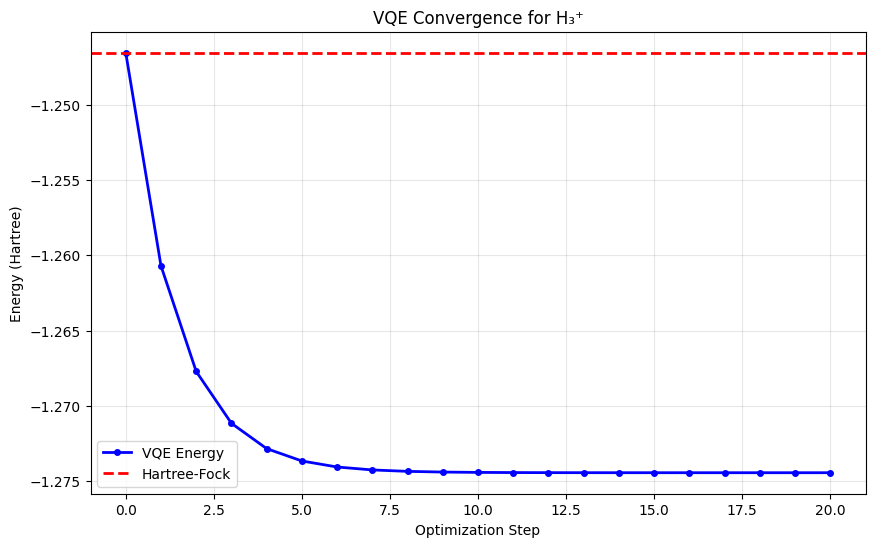

Energy improvement: 27.887 mHa over 20 steps


In [82]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(energy)), energy, 'b-o', linewidth=2, markersize=4, label='VQE Energy')
plt.axhline(y=h3_hf_energy, color='red', linestyle='--', linewidth=2, label='Hartree-Fock')
plt.xlabel('Optimization Step')
plt.ylabel('Energy (Hartree)')
plt.title('VQE Convergence for H₃⁺')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Energy improvement: {(energy[0] - energy[-1])*1000:.3f} mHa over {len(energy)-1} steps")

### The Ground State

In [83]:
@qml.qnode(dev)
def ground_state(params):
    ansatz(params)
    return qml.state()

ground_state(theta) # returns the values for alpha, beta, gamma

tensor([ 0.        +0.j,  0.        +0.j,  0.        +0.j,
        -0.09585862+0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
        -0.09586987+0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.99076743+0.j,  0.        +0.j,  0.        +0.